In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from matplotlib.collections import LineCollection
from tqdm.auto import tqdm

c:\Users\p.vladimirov\Work Folders\Desktop\EPIC\Monte Carlo\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## Basics of KDE

In [2]:
def kernel_density_estimation(x, data_points, bandwidth):
    """Calculate kernel density estimation."""
    return sum(norm_pdf((x - xi) / bandwidth) / bandwidth for xi in data_points) / len(data_points)

def norm_pdf(x):
    """Calculate the probability density function of the normal distribution."""
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)


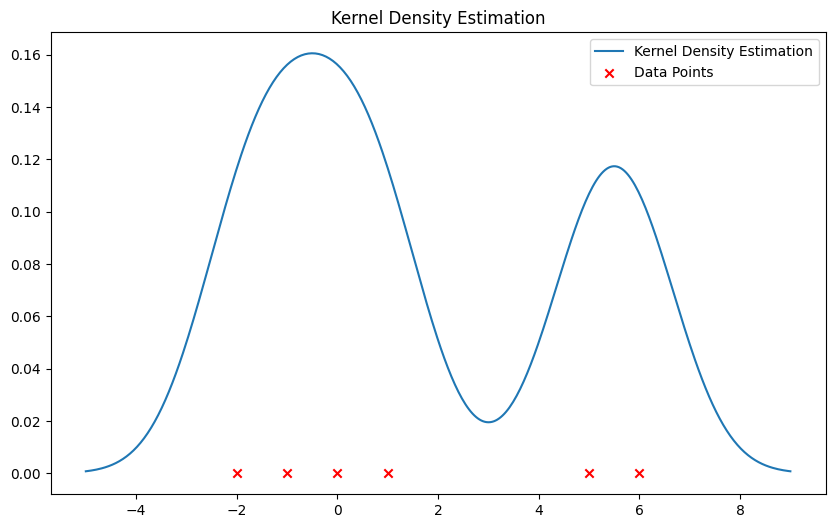

In [4]:
# Initial points
data_points = [-2, -1, 0, 1, 5, 6]
expanding_value = 5
x_values = np.linspace(min(data_points) - expanding_value, max(data_points) + expanding_value, 1000)
bandwidth = 1

x_values = np.linspace(min(data_points) - 3, max(data_points) + 3, 400)
y_values = [kernel_density_estimation(x, data_points, bandwidth) for x in x_values]

# Plot kernel density estimation
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Kernel Density Estimation')
plt.scatter(data_points, np.zeros_like(data_points), marker='x', color='red', label='Data Points')
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

---

## KDE for Uniform distribution 

In [5]:

data_points = np.random.uniform(0, 5, 75)
start_bandwidth = 5  # you can adjust the bandwidth as necessary

expanding_value = 5
x_values = np.linspace(min(data_points) - expanding_value, max(data_points) + expanding_value, 1000)

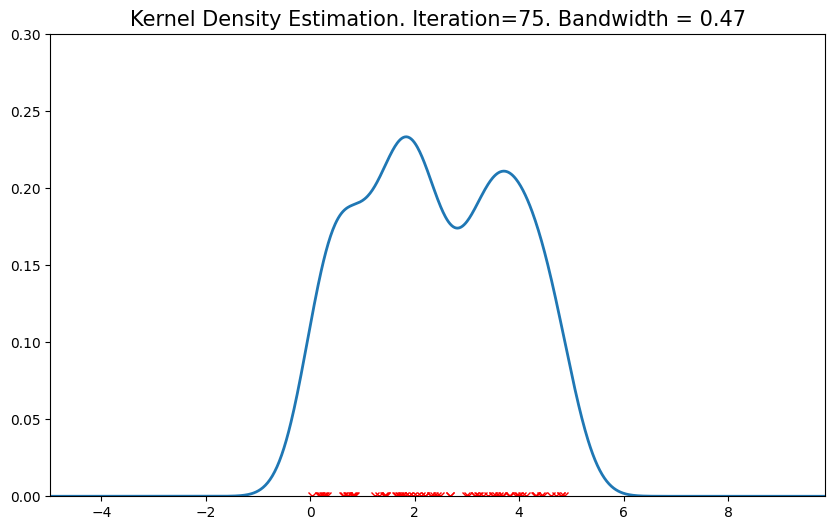

In [7]:
# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], lw=2)
point, = ax.plot([], [], marker='x', color='red', lw=0)


def init():
    """Initialize the line and the point"""
    line.set_data([], [])
    point.set_data([], [])
    ax.set_xlim(min(x_values), max(x_values))
    ax.set_ylim(0, .3)
    return line, point,

def update(i):
    """Update the plot for frame i"""
    bandwidth = start_bandwidth / ((i+1)**0.55)
    ax.set_title("Kernel Density Estimation. Iteration={:}. Bandwidth = {:.2f}".format(i+1, bandwidth), fontsize=15)
    y_values = [kernel_density_estimation(x, data_points[:i+1], bandwidth) for x in x_values]
    line.set_data(x_values, y_values)
    point.set_data(data_points[:i+1], np.zeros_like(data_points[:i+1]))
    return line, point,

ani = FuncAnimation(fig, update, frames=range(len(data_points)), init_func=init, blit=True)
ani.save("animation.gif", writer='pillow', fps=30)

---

## Finding anomaly boundaries with KDE and Metropolis-Hastings

In [8]:
def metropolis_hastings(p, iter=1000):
    """Perform the Metropolis-Hastings algorithm for MCMC."""
    x = np.random.uniform(low=min(x_values), high=max(x_values))  # Initial x value
    samples = np.zeros(iter)

    for i in range(iter):
        x_star = np.random.normal(x, 1)  # Proposed x value
        if np.random.rand() < min(1, p(x_star) / p(x)):  # Acceptance condition
            x = x_star
        samples[i] = x

    return samples



def slice_sampling(p, iter=1000, w=1):
    """Perform 1-dimensional slice sampling."""
    x = np.random.uniform(low=min(x_values), high=max(x_values))  # Initial x value
    samples = np.zeros(iter)

    for i in range(iter):
        u = np.random.uniform(0, p(x))  # Draw a vertical line
        x_l = x - w
        x_r = x + w
        
        # Stepping out procedure to find interval
        while p(x_l) > u:
            x_l -= w
        while p(x_r) > u:
            x_r += w
        
        while True:
            x_star = np.random.uniform(x_l, x_r)  # Proposed x value
            if p(x_star) >= u:  # Acceptance condition
                break
            elif x_star < x:
                x_l = x_star
            else:
                x_r = x_star
        
        x = x_star
        samples[i] = x

    return samples



def get_anomaly_bounds(samples, p_level=0.05):
    """Get the bounds for the anomalies."""
    return np.percentile(samples, [p_level/2*100, 100-p_level/2*100])


0  
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25  
26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50  
51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 

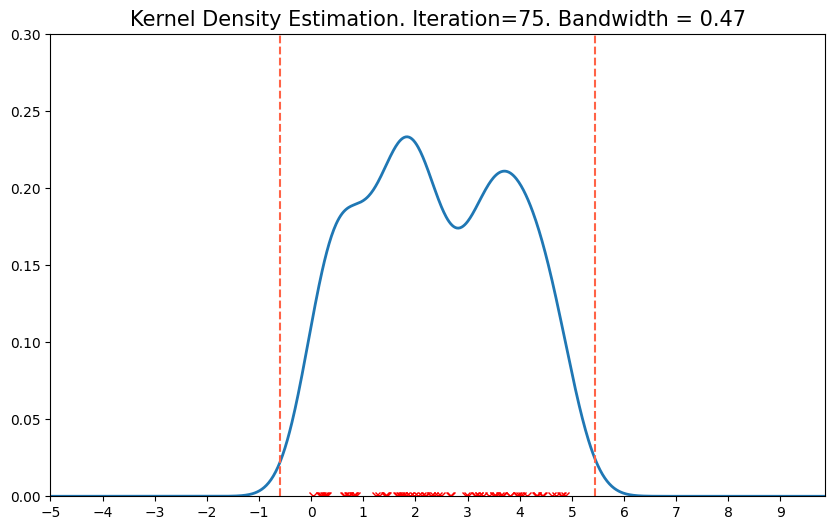

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], lw=2)
point, = ax.plot([], [], marker='x', color='red', lw=0)
plot_height = 0.3
vlines = LineCollection([], colors='tomato', linestyles='dashed', label='Anomaly Bounds')
ax.add_collection(vlines)

def init():
    """Initialize the line and the point"""
    line.set_data([], [])
    point.set_data([], [])
    vlines.set_segments([])
    ax.set_xlim(min(x_values), max(x_values))
    ax.set_ylim(0, plot_height)
    ax.set_xticks(range(-5, 10, 1))
    return line, point, vlines,

def update(i):
    """Update the plot for frame i"""
    print(i, sep=' ', end=' ', flush=True)
    if i % 25 == 0: print(' ')   
    bandwidth = start_bandwidth / ((i+1)**0.55)
    ax.set_title("Kernel Density Estimation. Iteration={:}. Bandwidth = {:.2f}".format(i+1, bandwidth), fontsize=15)
    y_values = [kernel_density_estimation(x, data_points[:i+1], bandwidth) for x in x_values]

    density_fn = lambda x: kernel_density_estimation(x, data_points[:i+1], bandwidth)
    samples = metropolis_hastings(density_fn, iter=10_000)
    anomaly_bounds = get_anomaly_bounds(samples, p_level=0.01)

    segments = [((x, 0), (x, plot_height)) for x in anomaly_bounds]
    vlines.set_segments(segments)
    line.set_data(x_values, y_values)
    point.set_data(data_points[:i+1], np.zeros_like(data_points[:i+1]))
    return line, point, vlines,

ani = FuncAnimation(fig, update, frames=range(len(data_points)), init_func=init, blit=True)
ani.save("animation.gif", writer='pillow', fps=15)

0  
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25  
26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50  
51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 

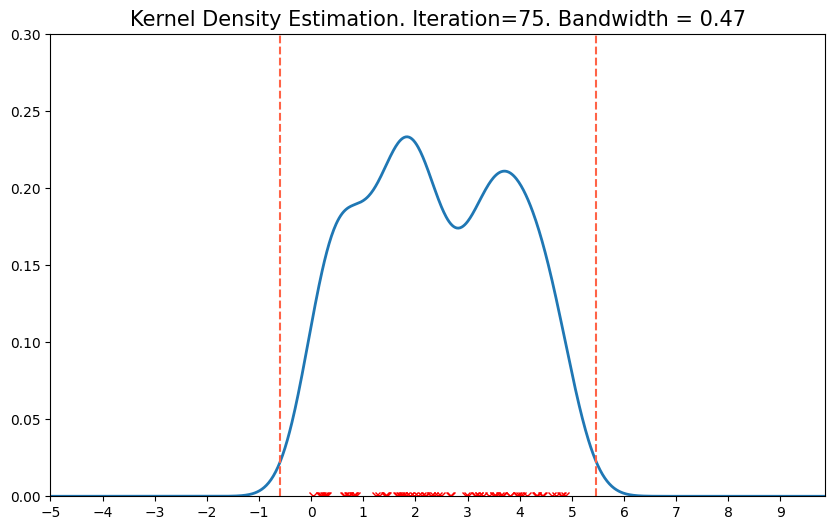

In [10]:
# the same as above, but with slice sampling

fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], lw=2)
point, = ax.plot([], [], marker='x', color='red', lw=0)
plot_height = 0.3
vlines = LineCollection([], colors='tomato', linestyles='dashed', label='Anomaly Bounds')
ax.add_collection(vlines)

def init():
    """Initialize the line and the point"""
    line.set_data([], [])
    point.set_data([], [])
    vlines.set_segments([])
    ax.set_xlim(min(x_values), max(x_values))
    ax.set_ylim(0, plot_height)
    ax.set_xticks(range(-5, 10, 1))
    return line, point, vlines,

def update(i):
    """Update the plot for frame i"""
    print(i, sep=' ', end=' ', flush=True)
    if i % 25 == 0: print(' ')   
    bandwidth = start_bandwidth / ((i+1)**0.55)
    ax.set_title("Kernel Density Estimation. Iteration={:}. Bandwidth = {:.2f}".format(i+1, bandwidth), fontsize=15)
    y_values = [kernel_density_estimation(x, data_points[:i+1], bandwidth) for x in x_values]

    density_fn = lambda x: kernel_density_estimation(x, data_points[:i+1], bandwidth)
    samples = slice_sampling(density_fn, iter=10_000, w=0.5)
    anomaly_bounds = get_anomaly_bounds(samples, p_level=0.01)

    segments = [((x, 0), (x, plot_height)) for x in anomaly_bounds]
    vlines.set_segments(segments)
    line.set_data(x_values, y_values)
    point.set_data(data_points[:i+1], np.zeros_like(data_points[:i+1]))
    return line, point, vlines,

ani = FuncAnimation(fig, update, frames=range(len(data_points)), init_func=init, blit=True)
ani.save("animation.gif", writer='pillow', fps=15)

---

## Testing on real data

In [12]:
real_data = [2.0, 1.0, 9.0, 7.0, 3.0, 16.0, 8.0, 5.0, 5.0, 5.0, 6.0, 2.0, 11.0, 11.0, 13.0, 11.0, 2.0, 11.0, 14.0, 15.0, 13.0, 14.0, 4.0, 4.0, 9.0, 11.0, 13.0, 12.0, 12.0, 2.0, 5.0, 12.0, 12.0, 14.0, 12.0, 15.0, 1.0, 15.0, 14.0, 14.0, 14.0, 13.0, 3.0, 12.0, 13.0, 12.0, 2.0, 2.0, 4.0, 7.0, 1.0, 6.0, 7.0, 3.0, 11.0, 12.0, 1.0, 7.0, 10.0, 14.0, 13.0, 15.0, 13.0, 7.0, 1.0, 13.0, 19.0, 12.0, 14.0, 11.0, 5.0, 8.0, 8.0, 15.0, 14.0, 13.0, 9.0, 3.0, 4.0, 14.0, 15.0, 12.0, 12.0, 12.0, 8.0, 2.0, 11.0, 14.0, 17.0, 16.0, 12.0, 2.0, 12.0, 16.0, 7.0]

In [19]:
2 * np.std(real_data)

9.553256467889588

In [20]:
np.mean(real_data)

9.452631578947368

(array([0.11403509, 0.03508772, 0.03508772, 0.04385965, 0.01754386,
        0.0877193 , 0.02631579, 0.00877193, 0.07017544, 0.12280702,
        0.1754386 , 0.05263158, 0.02631579, 0.00877193, 0.00877193]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ,
        14.2, 15.4, 16.6, 17.8, 19. ]),
 <BarContainer object of 15 artists>)

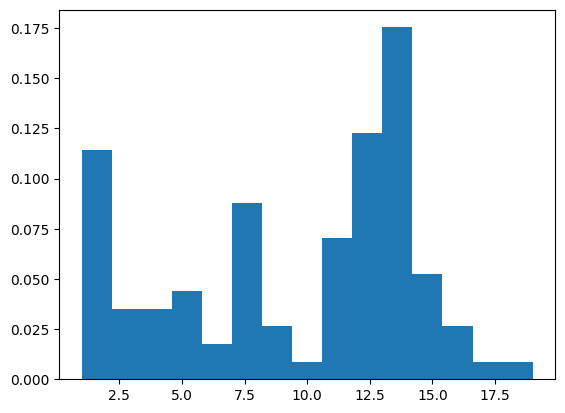

In [15]:
plt.hist(real_data, bins=15, density=True)

In [126]:
real_data_with_anomaly = real_data[:len(real_data)//2] + [-3] + real_data[len(real_data)//2:]

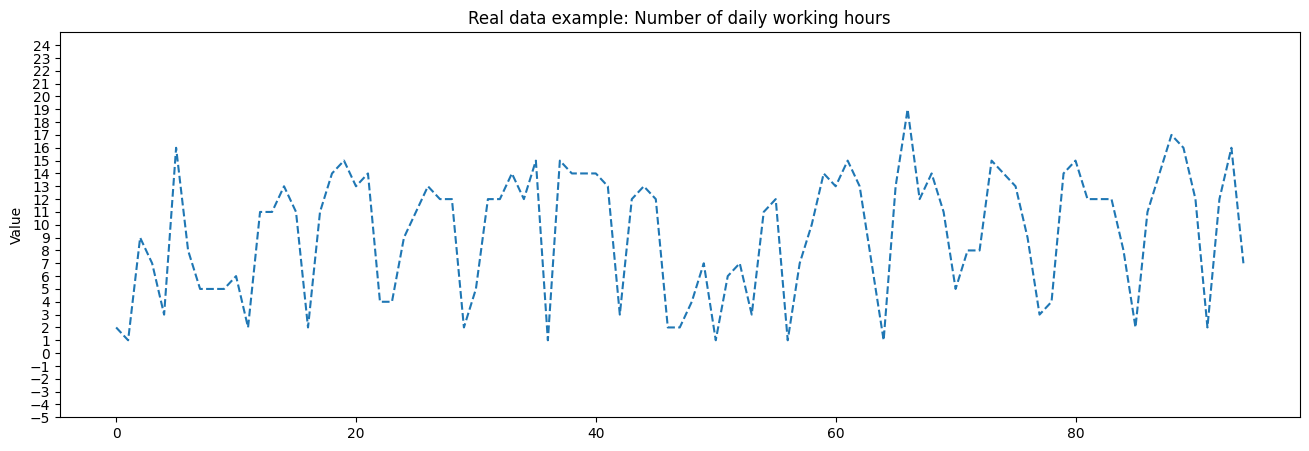

In [127]:
#plot real data
plt.figure(figsize=(16, 5))
plt.plot(real_data, '--')
plt.ylabel('Value')
plt.ylim(-2, 25)
plt.title('Real data example: Number of daily working hours')
plt.yticks(range(-5, 25, 1))
plt.show()

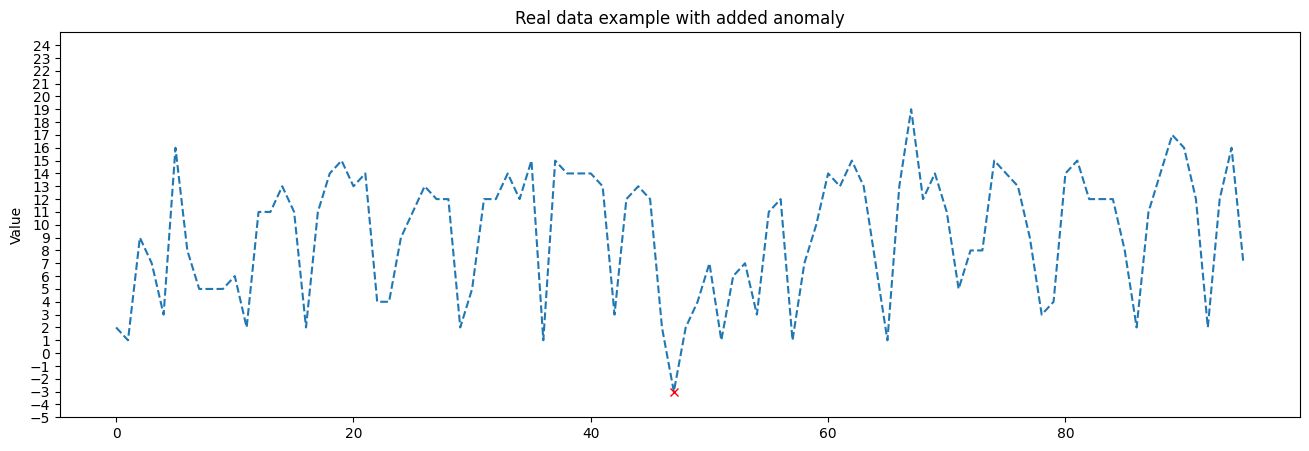

In [128]:
#plot real data
plt.figure(figsize=(16, 5))
plt.ylim(-2, 25)
plt.plot(real_data_with_anomaly, '--')
plt.plot(len(real_data)//2, real_data_with_anomaly[len(real_data)//2], marker='x', color='red', lw=0)
plt.ylabel('Value')
plt.title('Real data example with added anomaly')
plt.yticks(range(-5, 25, 1))
plt.show()

In [79]:
start_bandwidth = 10 
x_values = np.linspace(-5 , 30, 1000)

0  
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25  
26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50  
51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75  
76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 

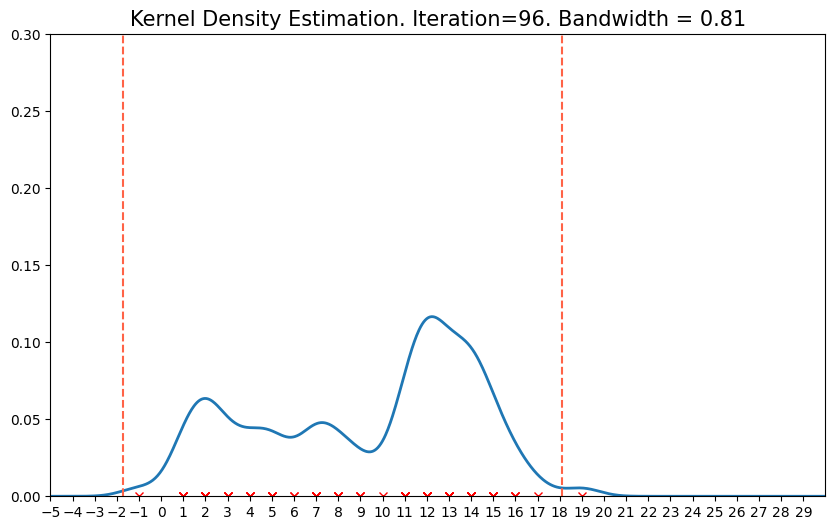

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], lw=2)
point, = ax.plot([], [], marker='x', color='red', lw=0)
plot_height = 0.3
vlines = LineCollection([], colors='tomato', linestyles='dashed', label='Anomaly Bounds')
ax.add_collection(vlines)
data_points = real_data_with_anomaly

def init():
    """Initialize the line and the point"""
    line.set_data([], [])
    point.set_data([], [])
    vlines.set_segments([])
    ax.set_xlim(min(x_values), max(x_values))
    ax.set_ylim(0, plot_height)
    ax.set_xticks(range(-5, 30, 1))
    return line, point, vlines,

def update(i):
    """Update the plot for frame i"""
    print(i, sep=' ', end=' ', flush=True)
    if i % 25 == 0: print(' ')   
    bandwidth = start_bandwidth / ((i+1)**0.55)
    ax.set_title("Kernel Density Estimation. Iteration={:}. Bandwidth = {:.2f}".format(i+1, bandwidth), fontsize=15)
    y_values = [kernel_density_estimation(x, data_points[:i+1], bandwidth) for x in x_values]

    density_fn = lambda x: kernel_density_estimation(x, data_points[:i+1], bandwidth)
    samples = metropolis_hastings(density_fn, iter=10_000)
    anomaly_bounds = get_anomaly_bounds(samples, p_level=0.01)

    segments = [((x, 0), (x, plot_height)) for x in anomaly_bounds]
    vlines.set_segments(segments)
    line.set_data(x_values, y_values)
    point.set_data(data_points[:i+1], np.zeros_like(data_points[:i+1]))
    return line, point, vlines,

ani = FuncAnimation(fig, update, frames=range(len(data_points)), init_func=init, blit=True)
ani.save("test_animation.gif", writer='pillow', fps=15)

In [129]:
data_points = real_data_with_anomaly
is_anomalies = np.zeros_like(data_points)
for i in tqdm(range(len(data_points))):
    bandwidth = start_bandwidth / ((i+1)**0.5)
    density_fn = lambda x: kernel_density_estimation(x, data_points[:i+1], bandwidth)
    samples = metropolis_hastings(density_fn, iter=10_000)
    anomaly_bounds = get_anomaly_bounds(samples, p_level=0.01)
    if data_points[i] < anomaly_bounds[0] or data_points[i] > anomaly_bounds[1]:
        is_anomalies[i] = 1

100%|██████████| 96/96 [04:19<00:00,  2.70s/it]


In [130]:
print(f"Total anomalies: {int(np.sum(is_anomalies))}")

Total anomalies: 1


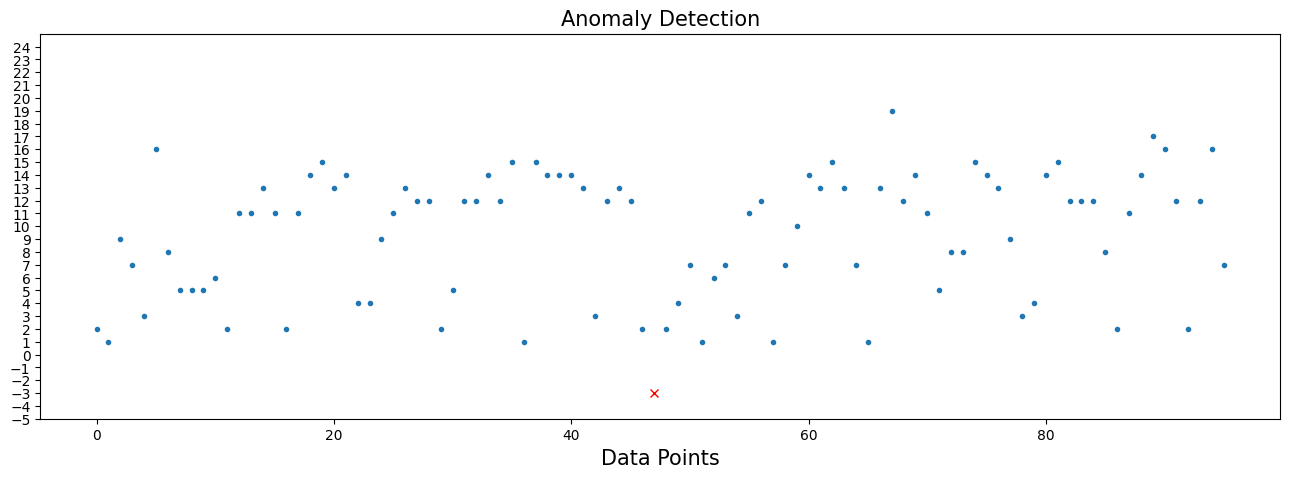

In [131]:
normal_points = np.array(data_points)[is_anomalies == 0]
anomaly_points = np.array(data_points)[is_anomalies == 1]
normal_points_x = np.arange(len(data_points))[is_anomalies == 0]
anomaly_points_x = np.arange(len(data_points))[is_anomalies == 1]

plt.figure(figsize=(16, 5))
plt.ylim(-2, 25)
plt.plot(normal_points_x, normal_points, '.', label='Normal')
plt.plot(anomaly_points_x, anomaly_points, 'x', label='Anomaly', color='red')
plt.title("Anomaly Detection", fontsize=15)
plt.xlabel("Data Points", fontsize=15)
plt.yticks(range(-5, 25, 1))
plt.show()

---

TODO:
 - add functionality of multivariate KDE and Metropolis-Hastings
 - more smart way of density function estimation for large number of points
 - less manual way of choosing bandwidth
 - checking for anomalies not only in the tails of distribution but also in the middle